In [1]:
!pip install --upgrade pip setuptools packaging wheel

In [2]:
!pip install kaggle

In [5]:
mkdir -p ~/.kaggle

In [6]:
# upload the kaggle.json file before running this
!mv kaggle.json ~/.kaggle/

In [7]:
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
!pip install opendatasets

In [9]:
!kaggle datasets download -d nasrulhakim86/coughvid-wav

Dataset URL: https://www.kaggle.com/datasets/nasrulhakim86/coughvid-wav
License(s): unknown
100%|██████████████████████████████████████▉| 8.61G/8.61G [01:01<00:00, 158MB/s]
100%|███████████████████████████████████████| 8.61G/8.61G [01:01<00:00, 151MB/s]


In [11]:
import zipfile
import os

def unzip_file(zip_path, extract_to):
    """
    Unzips a given ZIP file to a specified directory.

    :param zip_path: Path to the ZIP file.
    :param extract_to: Directory where files should be extracted.
    """
    # Ensure the extraction directory exists
    os.makedirs(extract_to, exist_ok=True)

    # Open and extract the zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
        print(f"Extracted {zip_path} to {extract_to}")

# Example usage
zip_file_path = "coughvid-wav.zip"  # Replace with your ZIP file path
extract_directory = "coughvid"  # Replace with desired extraction folder

unzip_file(zip_file_path, extract_directory)


Extracted coughvid-wav.zip to coughvid


In [1]:
import pandas as pd

df=pd.read_csv('coughvid/public_dataset/metadata_compiled.csv')
df.head()
df.to_csv("kaggle_metadata_compiled.csv")

In [51]:
metadata = pd.read_csv('kaggle_metadata_compiled.csv')

In [16]:
!pip install librosa

In [17]:
# utilities
import os
import sys
from tqdm import tqdm
import random

# data manipulation
import numpy as np
import pandas as pd
import librosa
import matplotlib.pyplot as plt

# # pycaret
# from pycaret.classification import *

# scipy
from scipy import signal
from scipy.io import wavfile
from scipy.signal import butter,filtfilt
#from scipy.signal import cwt
from scipy.signal import hilbert
from scipy.signal import resample
from scipy.signal import decimate
from scipy.signal import spectrogram
from scipy.signal.windows import get_window

# Set seed for reproducibility
seed_value= 32
os.environ['PYTHONHASHSEED']=str(seed_value)
random.seed(seed_value)
np.random.seed(seed_value)

# set variables
ROOT = 'coughvid/public_dataset/'
class_names = ['healthy','COVID-19','symptomatic']
audio_length = 22050

# load coughvid meta
data_raw = pd.read_csv(ROOT+'metadata_compiled.csv')
data_raw.head(3)

,uuid,datetime,cough_detected,SNR,latitude,longitude,age,gender,respiratory_condition,fever_muscle_pain,...,quality_4,cough_type_4,dyspnea_4,wheezing_4,stridor_4,choking_4,congestion_4,nothing_4,diagnosis_4,severity_4
0,00014dcc-0f06-4c27-8c7b-737b18a2cf4c,2020-11-25T18:58:50.488301+00:00,0.0155,7.326171,48.9,2.4,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00039425-7f3a-42aa-ac13-834aaa2b6b92,2020-04-13T21:30:59.801831+00:00,0.9609,16.151433,31.3,34.8,15.0,male,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0007c6f1-5441-40e6-9aaf-a761d8f2da3b,2020-10-18T15:38:38.205870+00:00,0.1643,16.217201,NaN,NaN,46.0,female,False,False,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
!pip install pydub

In [19]:
# plots and visualisation
import matplotlib.pyplot as plt
import plotly.graph_objects as ply_go
import plotly.figure_factory as ply_ff
import plotly.colors as ply_colors #.sequential.Oranges as orange_palette
from plotly.offline import init_notebook_mode, iplot
init_notebook_mode(connected=True)
import plotly.express as px
import matplotlib.pyplot as plt
import seaborn as sns
from pydub import AudioSegment

In [20]:
def split_by_physicians(df):
    column_names = ['uuid', 'datetime', 'cough_detected', 'SNR', 'latitude', 'longitude',
                    'age', 'gender', 'respiratory_condition', 'fever_muscle_pain', 'status',
                    'quality', 'cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking',
                    'congestion', 'nothing', 'diagnosis', 'severity' ]
    physician_01 = df.iloc[:, 0:21]
    physician_01 = physician_01[physician_01.quality_1.notna()].reset_index(drop=True)
    physician_01.columns = column_names

    physician_02 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 21:31]], axis=1)
    physician_02 = physician_02[physician_02.quality_2.notna()].reset_index(drop=True)
    physician_02.columns = column_names

    physician_03 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 31:41]], axis=1)
    physician_03 = physician_03[physician_03.quality_3.notna()].reset_index(drop=True)
    physician_03.columns = column_names

    physician_04 = pd.concat([df.iloc[:, 0:11], df.iloc[:, 41:51]], axis=1)
    physician_04 = physician_04[physician_04.quality_4.notna()].reset_index(drop=True)
    physician_04.columns = column_names
    return physician_01, physician_02, physician_03, physician_04

def process_csv(df):
    #split by physicians
    physician_01, physician_02, physician_03, physician_04 = split_by_physicians(df)
    # combine into one dataframe
    df = pd.concat([physician_01,physician_02,physician_03,physician_04]).reset_index(drop=True)
    # drop null status
    df = df[df.status.notna()]
    # drop cough_detected < 0.8
    df = df[df.cough_detected >= 0.8 ]
    # select good and ok quality
    df = df[df.quality == 'good']
    # shuffle
    df = df.sample(frac=1).reset_index(drop=True)
    df = df[['uuid','status','cough_type', 'dyspnea', 'wheezing', 'stridor', 'choking', 'congestion', 'severity']]
    return df

In [21]:
processed_df = process_csv(data_raw)
processed_df.head(3)
processed_df.to_csv("processed_df.csv")

In [22]:
import numpy as np
import librosa
import librosa.util
from tqdm import tqdm
import warnings

# Constants
AUDIO_LENGTH = 11025  # Set appropriate audio length for padding
MIN_SIGNAL_LENGTH = 1024  # Minimum length for processing
ROOT = 'coughvid/public_dataset/'

def get_appropriate_n_fft(signal_length: int) -> int:
    """
    Determines appropriate n_fft value based on signal length.

    Args:
        signal_length (int): Length of the audio signal

    Returns:
        int: Appropriate n_fft value that's a power of 2
    """
    # Find the largest power of 2 that's less than the signal length
    n_fft = 2**int(np.log2(signal_length))
    return min(n_fft, 2048)  # Cap at 2048 to prevent excessive computation


def segment_cough(
    x: np.ndarray,
    fs: int,
    cough_padding: float = 0.2,
    min_cough_len: float = 0.2,
    th_l_multiplier: float = 0.1,
    th_h_multiplier: float = 2.0
):
    """
    Segments an audio signal into individual coughs based on power using a hysteresis comparator.

    Args:
        x (np.ndarray): Audio signal.
        fs (int): Sampling frequency.
        cough_padding (float): Padding duration before and after a cough in seconds.
        min_cough_len (float): Minimum length of a cough segment in seconds.
        th_l_multiplier (float): Lower threshold multiplier for segmentation.
        th_h_multiplier (float): Higher threshold multiplier for segmentation.

    Returns:
        list: List of segmented cough audio clips.
        np.ndarray: Mask indicating cough positions.
    """
    try:
        cough_mask = np.zeros(len(x), dtype=bool)

        # Define hysteresis thresholds
        rms = np.sqrt(np.mean(np.square(x)))
        seg_th_l = th_l_multiplier * rms
        seg_th_h = th_h_multiplier * rms

        # Segment coughs
        cough_segments = []
        padding = round(fs * cough_padding)
        min_cough_samples = round(fs * min_cough_len)
        cough_start = 0
        cough_in_progress = False
        tolerance = round(0.01 * fs)
        below_th_counter = 0

        for i, sample in enumerate(x**2):
            if cough_in_progress:
                if sample < seg_th_l:
                    below_th_counter += 1
                    if below_th_counter > tolerance:
                        cough_end = min(i + padding, len(x) - 1)
                        cough_in_progress = False
                        if (cough_end + 1 - cough_start - 2 * padding > min_cough_samples):
                            cough_segments.append(x[cough_start:cough_end + 1])
                            cough_mask[cough_start:cough_end + 1] = True
                elif i == len(x) - 1:
                    cough_end = i
                    cough_in_progress = False
                    if (cough_end + 1 - cough_start - 2 * padding > min_cough_samples):
                        cough_segments.append(x[cough_start:cough_end + 1])
                else:
                    below_th_counter = 0
            else:
                if sample > seg_th_h:
                    cough_start = max(i - padding, 0)
                    cough_in_progress = True

        return cough_segments, cough_mask
    except Exception as e:
        print(f"Error in segment_cough: {e}")
        return [], np.zeros(len(x), dtype=bool)

def extract_features(audio_data: np.ndarray, sample_rate: int) -> np.ndarray:
    """
    Extracts comprehensive audio features with improved error handling and dynamic n_fft.

    Args:
        audio_data (np.ndarray): Audio signal.
        sample_rate (int): Sampling rate of the audio.

    Returns:
        np.ndarray: Feature vector containing all extracted features.
    """
    try:
        # Check if signal is too short
        if len(audio_data) < MIN_SIGNAL_LENGTH:
            print(f"Signal length {len(audio_data)} is too short for processing")
            return np.array([])

        features = []

        # Dynamically set n_fft based on signal length
        n_fft = get_appropriate_n_fft(len(audio_data))

        # Suppress specific warnings for short signals
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=UserWarning, module="librosa")

            # Get STFT with dynamic n_fft
            stft = np.abs(librosa.stft(audio_data, n_fft=n_fft))

            # 1. MFCC (40 features)
            mfcc = np.mean(librosa.feature.mfcc(
                y=audio_data,
                sr=sample_rate,
                n_mfcc=40,
                n_fft=n_fft
            ).T, axis=0)
            features.extend(mfcc)

            # 2. Chroma (12 features)
            chroma = np.mean(librosa.feature.chroma_stft(
                S=stft,
                sr=sample_rate,
                n_fft=n_fft
            ).T, axis=0)
            features.extend(chroma)

            # 3. Mel Spectrogram (128 features)
            mel = np.mean(librosa.feature.melspectrogram(
                y=audio_data,
                sr=sample_rate,
                n_mels=128,
                n_fft=n_fft
            ).T, axis=0)
            features.extend(mel)

            # 4. Spectral Contrast (7 features)
            contrast = np.mean(librosa.feature.spectral_contrast(
                S=stft,
                sr=sample_rate,
                n_bands=6,
                n_fft=n_fft
            ).T, axis=0)
            features.extend(contrast)

            # 5. Tonnetz (6 features)
            chromagram = librosa.feature.chroma_cqt(
                y=audio_data,
                sr=sample_rate,
                n_chroma=12,
                bins_per_octave=12
            )
            tonnetz = np.mean(librosa.feature.tonnetz(
                y=None,
                sr=sample_rate,
                chroma=chromagram
            ).T, axis=0)
            features.extend(tonnetz)

            # Remaining features with dynamic n_fft
            sc = np.mean(librosa.feature.spectral_centroid(S=stft, sr=sample_rate, n_fft=n_fft).T, axis=0)
            features.extend(sc)

            rolloff = np.mean(librosa.feature.spectral_rolloff(S=stft, sr=sample_rate, n_fft=n_fft).T, axis=0)
            features.extend(rolloff)

            zcr = np.mean(librosa.feature.zero_crossing_rate(audio_data).T, axis=0)
            features.extend(zcr)

            bandwidth = np.mean(librosa.feature.spectral_bandwidth(S=stft, sr=sample_rate, n_fft=n_fft).T, axis=0)
            features.extend(bandwidth)

            rmse = np.mean(librosa.feature.rms(S=stft).T, axis=0)
            features.extend(rmse)

            flatness = np.mean(librosa.feature.spectral_flatness(S=stft).T, axis=0)
            features.extend(flatness)

        return np.array(features)
    except Exception as e:
        print(f"Error in extract_features: {e}")
        return np.array([])

def load_features(df) -> tuple[np.ndarray, np.ndarray]:
    """
    Loads and processes audio features with improved error handling.

    Args:
        df (pd.DataFrame): DataFrame containing the UUIDs of the audio files.

    Returns:
        tuple: (Array of file names, Array of extracted features)
    """
    all_data, all_fnames = [], []

    for idx in tqdm(range(len(df))):
        try:
            fname = df.uuid.iloc[idx]
            path = f"{ROOT}{fname}.wav"

            # Load audio file
            audio, sample_rate = librosa.load(path, mono=True)

            # Skip if audio is too short
            if len(audio) < MIN_SIGNAL_LENGTH:
                print(f"Skipping {fname}: audio too short ({len(audio)} samples)")
                continue

            # Segment coughs
            cough_segments, _ = segment_cough(
                audio,
                sample_rate,
                min_cough_len=0.1,
                cough_padding=0.1,
                th_l_multiplier=0.1,
                th_h_multiplier=2.0
            )

            # Process each segment
            for segment in cough_segments:
                if len(segment) > MIN_SIGNAL_LENGTH:
                    # Pad audio to fixed length
                    audio_pad = librosa.util.fix_length(segment, size=AUDIO_LENGTH)

                    feature = extract_features(audio_pad, sample_rate)
                    if feature.size > 0:
                        all_data.append(feature)
                        all_fnames.append(fname)
                else:
                    print(f"Skipping segment in {fname}: too short ({len(segment)} samples)")

        except Exception as e:
            print(f"Error processing file {fname}: {e}")
            continue

    return np.array(all_fnames), np.array(all_data)

In [24]:
uuid, X = load_features(processed_df)

100%|██████████| 1680/1680 [08:04<00:00,  3.46it/s]


In [25]:
all_df=pd.DataFrame(X)

In [26]:
all_df

,0,1,2,3,4,5,6,7,8,9,...,189,190,191,192,193,194,195,196,197,198
0,-213.578674,87.420441,8.120502,51.719814,-67.246979,44.662533,-22.648973,12.401956,-17.936529,-15.618293,...,-0.020818,0.003718,0.000992,0.012617,3009.872755,5436.644398,0.208052,2126.430408,0.093540,0.011069
1,-325.151825,53.615299,-15.618591,24.316906,-54.825085,27.862598,-28.378351,10.236363,-22.203346,-10.343152,...,-0.016035,0.032126,-0.004162,0.005517,3018.623716,5379.875044,0.230091,2060.094212,0.042036,0.100259
2,-174.282196,78.058975,-61.197327,56.193577,-15.478659,19.696732,-44.306610,-5.602448,-43.272964,-13.734656,...,0.018807,-0.000162,0.011329,-0.000009,2598.954373,5024.087802,0.137562,2031.809990,0.088194,0.092260
3,-284.938446,162.992676,3.002870,22.917351,23.743042,2.856206,-20.336641,-19.091980,-11.124667,-8.366435,...,-0.008920,0.009923,0.004141,0.011742,753.145319,1463.279031,0.030873,963.949721,0.091859,0.000917
4,-295.700470,151.326584,1.158798,23.890572,22.702789,4.372093,-23.279707,-19.368294,-7.834184,-12.167913,...,-0.028442,-0.050298,0.009079,-0.008618,970.866007,1967.351740,0.040039,1181.098836,0.084408,0.006088
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6795,-346.509003,6.966104,-16.550467,-27.313238,-7.061436,7.873379,1.458615,-1.802957,-18.721107,-6.133872,...,-0.024488,0.044792,0.005253,0.006400,4507.596122,7484.745650,0.308882,2697.684071,0.028118,0.163145
6796,-111.177246,121.665771,-29.421955,37.200485,-34.043190,38.686745,-20.979832,11.939795,-24.390383,1.118069,...,-0.011368,-0.006559,-0.004490,0.015612,2145.569505,4437.797408,0.102095,2089.718269,0.152203,0.092638
6797,-43.218410,119.670341,-54.362411,68.104683,-55.959366,40.417637,-47.330261,6.877280,-15.923014,-7.834118,...,0.035411,-0.039283,-0.009186,0.005389,2551.672605,5116.093306,0.153653,2098.953270,0.135936,0.003740
6798,-160.244431,128.252823,-36.878441,37.406818,-42.005444,37.956112,-31.008709,-4.634426,-13.570075,-7.228926,...,-0.002432,0.014410,0.002265,-0.002261,1970.490362,3727.201705,0.118652,1716.799223,0.090060,0.001086


In [27]:
# Store each features in different dataframe so you can choose to train all features or individual
X_mfcc = X[:, 0:40]               # 40 features
X_chroma = X[:, 40:52]            # 12 features
X_mel = X[:, 52:180]              # 128 features
X_contrast = X[:, 180:187]        # 7 features
X_tonnetz = X[:, 187:193]         # 6 features
X_centroid = X[:, 193:194]        # 1 feature
X_rolloff = X[:, 194:195]         # 1 feature
X_zcr = X[:, 195:196]            # 1 feature
X_bandwidth = X[:, 196:197]       # 1 feature
X_rmse = X[:, 197:198]           # 1 feature
X_flatness = X[:, 198:199]        # 1 feature

# Create uuid dataframe
uuid_df = pd.DataFrame({'uuid':uuid})

# mfcc only
mfcc_df = pd.DataFrame(X_mfcc)
mfcc_df.columns=["mfcc"+str(i) for i in range(1, X_mfcc.shape[1]+1)]
all_mfcc_df = pd.concat([uuid_df, mfcc_df], axis=1)

# mel spectogram only
mel_df = pd.DataFrame(X_mel)
mel_df.columns=["mel"+str(i) for i in range(1, X_mel.shape[1]+1)]
all_mel_df = pd.concat([uuid_df, mel_df], axis=1)

# chroma only
chroma_df = pd.DataFrame(X_chroma)
chroma_df.columns=["chr"+str(i) for i in range(1, X_chroma.shape[1]+1)]
all_chroma_df = pd.concat([uuid_df, chroma_df], axis=1)

# contrast only
contrast_df = pd.DataFrame(X_contrast)
contrast_df.columns=["con"+str(i) for i in range(1, X_contrast.shape[1]+1)]
all_contrast_df = pd.concat([uuid_df, contrast_df], axis=1)

# tonnetz only
tonnetz_df = pd.DataFrame(X_tonnetz)
tonnetz_df.columns=["ton"+str(i) for i in range(1, X_tonnetz.shape[1]+1)]
all_tonnetz_df = pd.concat([uuid_df, tonnetz_df], axis=1)

# Single feature dataframes
centroid_df = pd.DataFrame(X_centroid, columns=['centroid'])
all_centroid_df = pd.concat([uuid_df, centroid_df], axis=1)

rolloff_df = pd.DataFrame(X_rolloff, columns=['rolloff'])
all_rolloff_df = pd.concat([uuid_df, rolloff_df], axis=1)

zcr_df = pd.DataFrame(X_zcr, columns=['zcr'])
all_zcr_df = pd.concat([uuid_df, zcr_df], axis=1)

bandwidth_df = pd.DataFrame(X_bandwidth, columns=['bandwidth'])
all_bandwidth_df = pd.concat([uuid_df, bandwidth_df], axis=1)

rmse_df = pd.DataFrame(X_rmse, columns=['rmse'])
all_rmse_df = pd.concat([uuid_df, rmse_df], axis=1)

flatness_df = pd.DataFrame(X_flatness, columns=['flatness'])
all_flatness_df = pd.concat([uuid_df, flatness_df], axis=1)

# all features
all_df = pd.concat([uuid_df, mfcc_df, mel_df, chroma_df, contrast_df,
                    tonnetz_df, centroid_df, rolloff_df, zcr_df,
                    bandwidth_df, rmse_df, flatness_df], axis=1)
all_df.head(3)

,uuid,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,ton3,ton4,ton5,ton6,centroid,rolloff,zcr,bandwidth,rmse,flatness
0,fed03a5c-6329-488c-a031-213ccdceabcf,-213.578674,87.420441,8.120502,51.719814,-67.246979,44.662533,-22.648973,12.401956,-17.936529,...,-0.020818,0.003718,0.000992,0.012617,3009.872755,5436.644398,0.208052,2126.430408,0.093540,0.011069
1,fed03a5c-6329-488c-a031-213ccdceabcf,-325.151825,53.615299,-15.618591,24.316906,-54.825085,27.862598,-28.378351,10.236363,-22.203346,...,-0.016035,0.032126,-0.004162,0.005517,3018.623716,5379.875044,0.230091,2060.094212,0.042036,0.100259
2,09aaa59d-0263-4475-ab15-3bf00a32c0ef,-174.282196,78.058975,-61.197327,56.193577,-15.478659,19.696732,-44.306610,-5.602448,-43.272964,...,0.018807,-0.000162,0.011329,-0.000009,2598.954373,5024.087802,0.137562,2031.809990,0.088194,0.092260


In [28]:
all_df.shape

(6800, 200)

In [29]:
# Select only 'status' instead of 'cough_type'
label_df_status = processed_df[['uuid', 'status']].reset_index(drop=True)

# Merge features and labels
dataset_status = pd.merge(all_df, label_df_status, on='uuid')

# Remove any unknown or null values in 'status'
dataset_status = dataset_status[dataset_status.status.isin(['healthy', 'COVID-19', 'symptomatic'])]

dataset_status.head(3)

,uuid,mfcc1,mfcc2,mfcc3,mfcc4,mfcc5,mfcc6,mfcc7,mfcc8,mfcc9,...,ton4,ton5,ton6,centroid,rolloff,zcr,bandwidth,rmse,flatness,status
0,fed03a5c-6329-488c-a031-213ccdceabcf,-213.578674,87.420441,8.120502,51.719814,-67.246979,44.662533,-22.648973,12.401956,-17.936529,...,0.003718,0.000992,0.012617,3009.872755,5436.644398,0.208052,2126.430408,0.093540,0.011069,healthy
1,fed03a5c-6329-488c-a031-213ccdceabcf,-325.151825,53.615299,-15.618591,24.316906,-54.825085,27.862598,-28.378351,10.236363,-22.203346,...,0.032126,-0.004162,0.005517,3018.623716,5379.875044,0.230091,2060.094212,0.042036,0.100259,healthy
2,09aaa59d-0263-4475-ab15-3bf00a32c0ef,-174.282196,78.058975,-61.197327,56.193577,-15.478659,19.696732,-44.306610,-5.602448,-43.272964,...,-0.000162,0.011329,-0.000009,2598.954373,5024.087802,0.137562,2031.809990,0.088194,0.092260,healthy


In [30]:
dataset_status.shape

(8388, 201)

In [31]:
print("\n[✓] Class Distribution before SMOTE")
dataset_status.status.value_counts()


[✓] Class Distribution before SMOTE


symptomatic    3570
healthy        2567
COVID-19       2251
Name: status, dtype: int64

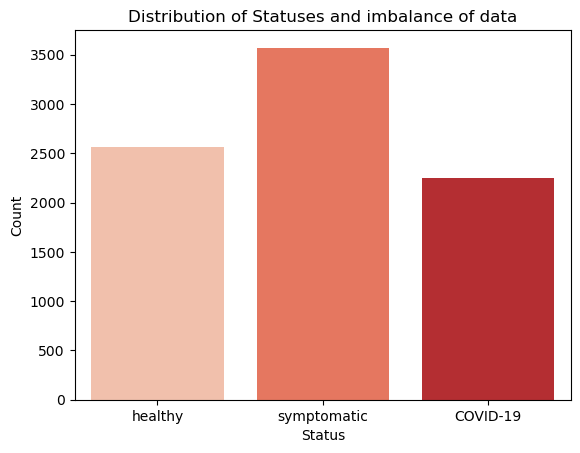

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

status_counts = dataset_status.status.value_counts()

coral_palette = sns.color_palette("Reds", n_colors=len(status_counts))

# Create the countplot with the coral palette
sns.countplot(x='status', data=dataset_status, palette=coral_palette)

plt.title('Distribution of Statuses and imbalance of data')
plt.xlabel('Status')
plt.ylabel('Count')
plt.show()

In [26]:
dataset_status.columns

Index(['uuid', 'mfcc1', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7',
       'mfcc8', 'mfcc9',
       ...
       'ton4', 'ton5', 'ton6', 'centroid', 'rolloff', 'zcr', 'bandwidth',
       'rmse', 'flatness', 'status'],
      dtype='object', length=201)

In [58]:
dataset_status.to_csv("data_to_train.csv")

In [35]:
import pandas as pd

# Assuming dataset_status is your DataFrame

for col in dataset_status.columns:
    print(col)

uuid
mfcc1
mfcc2
mfcc3
mfcc4
mfcc5
mfcc6
mfcc7
mfcc8
mfcc9
mfcc10
mfcc11
mfcc12
mfcc13
mfcc14
mfcc15
mfcc16
mfcc17
mfcc18
mfcc19
mfcc20
mfcc21
mfcc22
mfcc23
mfcc24
mfcc25
mfcc26
mfcc27
mfcc28
mfcc29
mfcc30
mfcc31
mfcc32
mfcc33
mfcc34
mfcc35
mfcc36
mfcc37
mfcc38
mfcc39
mfcc40
mel1
mel2
mel3
mel4
mel5
mel6
mel7
mel8
mel9
mel10
mel11
mel12
mel13
mel14
mel15
mel16
mel17
mel18
mel19
mel20
mel21
mel22
mel23
mel24
mel25
mel26
mel27
mel28
mel29
mel30
mel31
mel32
mel33
mel34
mel35
mel36
mel37
mel38
mel39
mel40
mel41
mel42
mel43
mel44
mel45
mel46
mel47
mel48
mel49
mel50
mel51
mel52
mel53
mel54
mel55
mel56
mel57
mel58
mel59
mel60
mel61
mel62
mel63
mel64
mel65
mel66
mel67
mel68
mel69
mel70
mel71
mel72
mel73
mel74
mel75
mel76
mel77
mel78
mel79
mel80
mel81
mel82
mel83
mel84
mel85
mel86
mel87
mel88
mel89
mel90
mel91
mel92
mel93
mel94
mel95
mel96
mel97
mel98
mel99
mel100
mel101
mel102
mel103
mel104
mel105
mel106
mel107
mel108
mel109
mel110
mel111
mel112
mel113
mel114
mel115
mel116
mel117
mel118
mel119

In [36]:
pip install colorama

Note: you may need to restart the kernel to use updated packages.


In [37]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from colorama import Fore, Back, Style, init
from tabulate import tabulate
import warnings
warnings.filterwarnings('ignore')

def analyze_correlations(df, threshold=0.8):
    """
    Analyze correlations and identify highly correlated pairs
    """
    init()  # Initialize colorama

    # Get numeric columns
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

    # Calculate correlation matrix
    corr_matrix = df[numeric_cols].corr().abs()

    # Find highly correlated pairs
    high_corr_pairs = []
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                high_corr_pairs.append({
                    'Feature 1': corr_matrix.columns[i],
                    'Feature 2': corr_matrix.columns[j],
                    'Correlation': corr_matrix.iloc[i, j]
                })

    # Create DataFrame of correlated pairs
    corr_pairs_df = pd.DataFrame(high_corr_pairs)

    # Sort by correlation strength
    if not corr_pairs_df.empty:
        corr_pairs_df = corr_pairs_df.sort_values('Correlation', ascending=False)

    return corr_pairs_df

def visualize_correlations(df, corr_pairs_df):
    """
    Create visualizations for correlation analysis
    """
    # Create correlation heatmap
    plt.figure(figsize=(12, 8))
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    sns.heatmap(df[numeric_cols].corr(),
                cmap='RdYlBu_r',
                center=0,
                annot=False)
    plt.title('Feature Correlation Heatmap', pad=20)
    plt.tight_layout()

    # Create scatter plots for top correlated pairs
    if not corr_pairs_df.empty:
        top_pairs = corr_pairs_df.head(3)  # Show top 3 pairs
        plt.figure(figsize=(15, 5))
        for i, (_, row) in enumerate(top_pairs.iterrows(), 1):
            plt.subplot(1, 3, i)
            sns.scatterplot(data=df, x=row['Feature 1'], y=row['Feature 2'], alpha=0.5)
            plt.title(f'Correlation: {row["Correlation"]:.2f}')
            plt.xticks(rotation=45)
            plt.ylabel('')
        plt.tight_layout()

def remove_correlated_features(df, corr_pairs_df):
    """
    Remove one feature from each highly correlated pair
    """
    features_to_drop = set()

    if not corr_pairs_df.empty:
        for _, row in corr_pairs_df.iterrows():
            # Keep the first feature, drop the second
            features_to_drop.add(row['Feature 2'])

    # Create new dataframe without correlated features
    df_decorrelated = df.drop(columns=list(features_to_drop))

    return df_decorrelated, features_to_drop

def print_analysis_results(corr_pairs_df, dropped_features):
    """
    Print analysis results using colorama
    """
    print(f"{Fore.CYAN}=== Correlation Analysis Results ==={Style.RESET_ALL}")
    print(f"\n{Fore.GREEN}Number of highly correlated pairs: {Style.RESET_ALL}{len(corr_pairs_df)}")

    if not corr_pairs_df.empty:
        print(f"\n{Fore.YELLOW}Highly Correlated Feature Pairs:{Style.RESET_ALL}")
        print(tabulate(corr_pairs_df, headers='keys', tablefmt='fancy_grid', floatfmt='.3f'))

    print(f"\n{Fore.RED}Features Removed:{Style.RESET_ALL}")
    for feature in dropped_features:
        print(f"- {feature}")

def suggest_additional_checks():
    """
    Provide additional suggestions for feature analysis
    """
    suggestions = [
        ("Variance Analysis", "Check for low-variance features that might not contribute much information"),
        ("Mutual Information", "Calculate mutual information scores with target variable"),
        ("PCA Analysis", "Consider using PCA for dimensionality reduction while preserving variance"),
        ("Feature Importance", "Use model-based feature importance (Random Forest, XGBoost)"),
        ("ANOVA F-value", "For classification tasks, use ANOVA F-values to select features"),
        ("Chi-squared test", "For categorical features, use chi-squared tests for feature selection"),
        ("Recursive Feature Elimination", "Use RFE with cross-validation to select optimal features"),
        ("L1-based selection", "Use Lasso or ElasticNet for feature selection")
    ]

    print(f"\n{Fore.MAGENTA}=== Additional Analysis Suggestions ==={Style.RESET_ALL}")
    for method, description in suggestions:
        print(f"\n{Fore.BLUE}{method}:{Style.RESET_ALL}")
        print(f"  {description}")

def run_correlation_analysis(df):
    """
    Run the complete correlation analysis pipeline
    """
    # Analyze correlations
    corr_pairs_df = analyze_correlations(dataset_status)

    # Create visualizations
    visualize_correlations(dataset_status, corr_pairs_df)

    # Remove correlated features
    df_decorrelated, dropped_features = remove_correlated_features(dataset_status, corr_pairs_df)

    # Print results
    print_analysis_results(corr_pairs_df, dropped_features)

    # Save decorrelated dataset
    df_decorrelated.to_csv('decorrelated_features.csv', index=False)

    # Provide additional suggestions
    suggest_additional_checks()

    return df_decorrelated

In [38]:
df = pd.read_csv("processed_df.csv")

=== Correlation Analysis Results ===

Number of highly correlated pairs: 106

Highly Correlated Feature Pairs:
╒═════╤═════════════╤═════════════╤═══════════════╕
│     │ Feature 1   │ Feature 2   │   Correlation │
╞═════╪═════════════╪═════════════╪═══════════════╡
│  83 │ mel124      │ mel123      │         0.961 │
├─────┼─────────────┼─────────────┼───────────────┤
│  88 │ mel128      │ mel127      │         0.954 │
├─────┼─────────────┼─────────────┼───────────────┤
│ 100 │ rolloff     │ centroid    │         0.951 │
├─────┼─────────────┼─────────────┼───────────────┤
│  81 │ mel123      │ mel122      │         0.947 │
├─────┼─────────────┼─────────────┼───────────────┤
│  73 │ mel118      │ mel117      │         0.940 │
├─────┼─────────────┼─────────────┼───────────────┤
│  70 │ mel116      │ mel115      │         0.931 │
├─────┼─────────────┼─────────────┼───────────────┤
│  72 │ mel118      │ mel116      │         0.924 │
├─────┼─────────────┼─────────────┼───────────────┤
│ 104

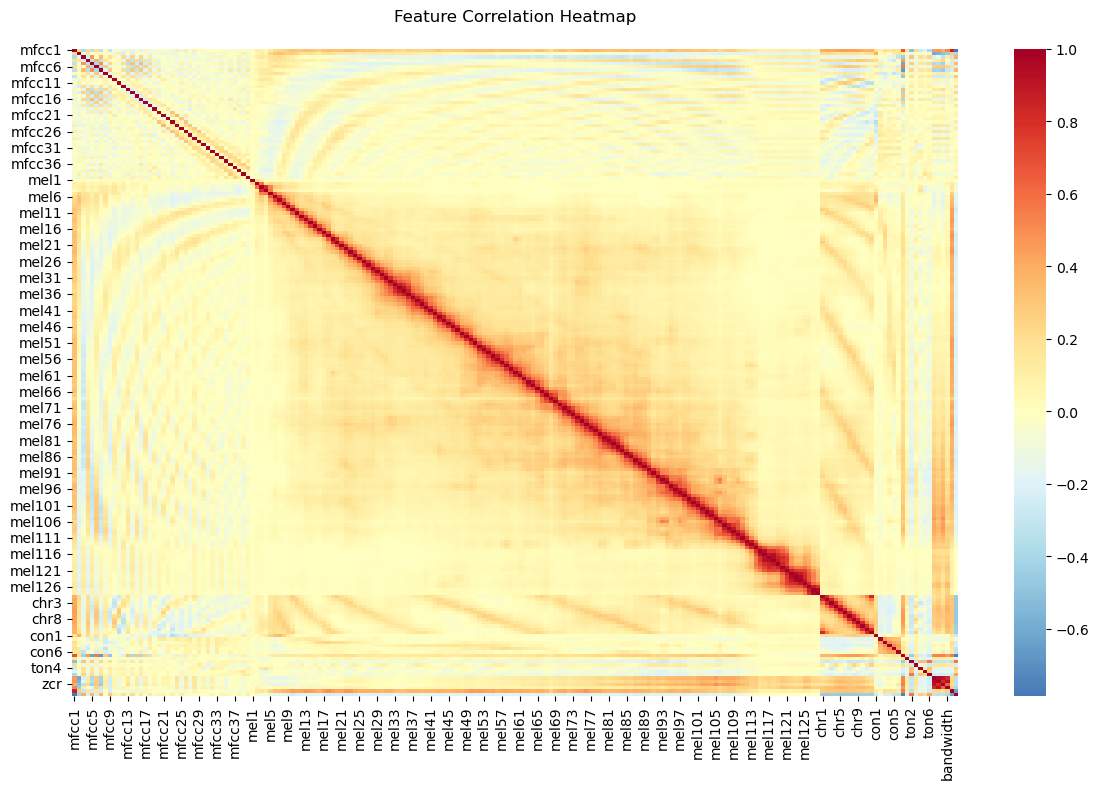

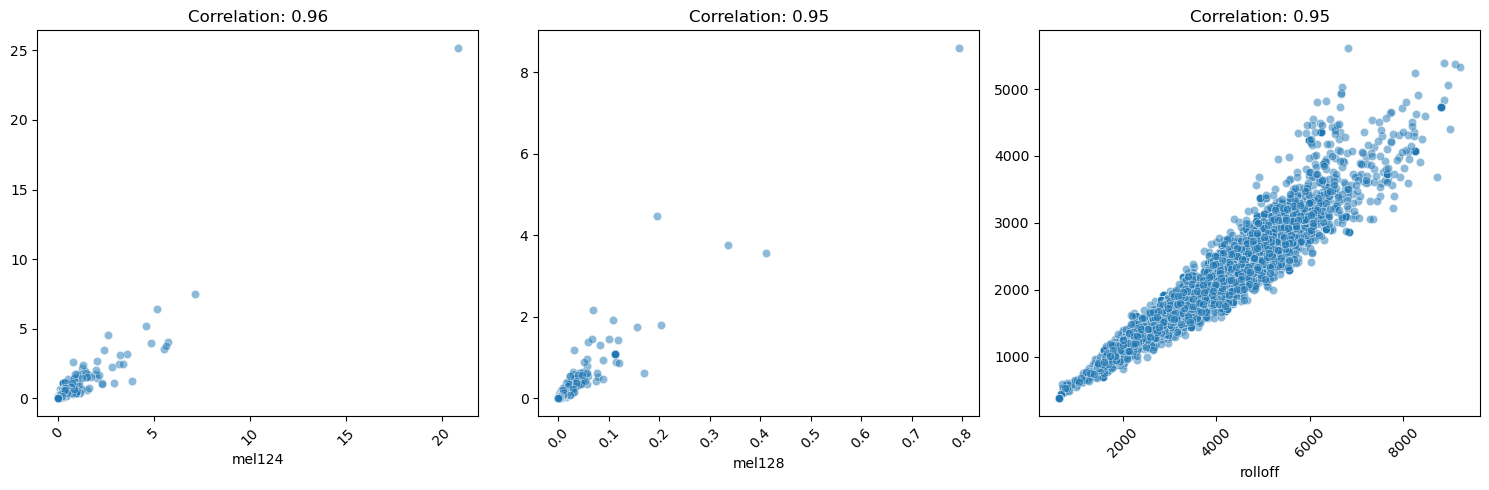

In [39]:
df_decorrelated = run_correlation_analysis(df)

In [40]:
decorrelated = pd.read_csv('decorrelated_features.csv')

In [41]:
decorrelated.columns

Index(['uuid', 'mfcc2', 'mfcc3', 'mfcc4', 'mfcc5', 'mfcc6', 'mfcc7', 'mfcc8',
       'mfcc9', 'mfcc10',
       ...
       'ton2', 'ton3', 'ton4', 'ton5', 'ton6', 'zcr', 'bandwidth', 'rmse',
       'flatness', 'status'],
      dtype='object', length=105)

In [42]:
!pip install tensorflow-addons

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 30.5 MB/s eta 0:00:00


TIMEDISTRIBUTED CNN + BILSTM

In [43]:
!pip install tensorflow

In [44]:
!pip install imblearn

In [26]:
pip install --no-cache-dir --force-reinstall "numpy==1.26.4"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 506.3 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.2.3
    Uninstalling numpy-2.2.3:
      Successfully uninstalled numpy-2.2.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mkl-fft 1.3.11 requires mkl, which is not installed.
Note: you may need to restart the kernel to use updated packages.


In [79]:
# System imports
import os
import numpy as np
import joblib

# Data processing and visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from colorama import Fore, Style

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.utils.class_weight import compute_class_weight
from imblearn.over_sampling import SMOTE

# TensorFlow/Keras imports
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input,
    Conv2D,
    MaxPooling2D,
    BatchNormalization,
    Dropout,
    Flatten,
    Dense,
    LSTM,
    TimeDistributed
)
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Set random seeds for reproducibility
np.random.seed(612)
tf.random.set_seed(612)

In [80]:
# main.py
import os
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, LSTM, Dense, Dropout, BatchNormalization, TimeDistributed
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import label_binarize
from colorama import Fore, Style
import joblib
import tensorflow as tf

class EnhancedCovidModelTrainerCNNLSTM:
    def __init__(self, save_dir='model_artifacts'):
        self.save_dir = save_dir
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        self.scaler = MinMaxScaler(feature_range=(-1, 1))
        self.label_encoder = LabelEncoder()
        self.model = None
        self.height = 1
        self.width = None
        self.channels = 1
        self.lstm_units = 128
        self.sequence_length = 1
        self.dropout_rate = 0.3
        self.l2_lambda = 0.01
        self.metrics = None
        self.test_accuracy = None

    def augment_data(self, X_train):
        noise = np.random.normal(0, 0.01, X_train.shape)
        X_train_noisy = X_train + noise
        X_train_scaled = X_train * np.random.uniform(0.95, 1.05, X_train.shape)
        X_train_combined = np.concatenate([X_train, X_train_noisy, X_train_scaled])
        return X_train_combined

    def preprocess_data(self, sampled_data):
        print(Fore.BLUE + "[*] Loading and splitting data..." + Style.RESET_ALL)
        y_label = 'status'
        X = sampled_data.drop(columns=[y_label, 'uuid'])
        y = sampled_data[y_label]

        # 1. Split FIRST
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=612, stratify=y
        )

        # 2. Scale and Encode on TRAINING data ONLY
        print(Fore.BLUE + "[*] Normalizing features..." + Style.RESET_ALL)
        self.scaler.fit(X_train)
        X_train_norm = self.scaler.transform(X_train)
        X_test_norm = self.scaler.transform(X_test)

        print(Fore.BLUE + "[*] Encoding labels..." + Style.RESET_ALL)
        self.label_encoder.fit(y_train)
        y_train_enc = self.label_encoder.transform(y_train)
        y_test_enc = self.label_encoder.transform(y_test)

        # NaN handling
        nan_rows_train = np.isnan(X_train_norm).any(axis=1)
        X_train_norm = X_train_norm[~nan_rows_train]
        y_train_enc = y_train_enc[~nan_rows_train]

        nan_rows_test = np.isnan(X_test_norm).any(axis=1)
        X_test_norm = X_test_norm[~nan_rows_test]
        y_test_enc = y_test_enc[~nan_rows_test]

        self.width = X_train_norm.shape[1]

        print(Fore.BLUE + "[*] Reshaping data for CNN+LSTM..." + Style.RESET_ALL)
        X_train_norm = X_train_norm.reshape(-1, self.sequence_length, self.height, self.width, self.channels)
        X_test_norm = X_test_norm.reshape(-1, self.sequence_length, self.height, self.width, self.channels)

        # 3. SMOTE on TRAINING data ONLY
        print(Fore.GREEN + "\n[✓] Class Distribution BEFORE SMOTE:" + Style.RESET_ALL)
        print(pd.Series(y_train_enc).value_counts())

        print(Fore.BLUE + "[*] Applying SMOTE..." + Style.RESET_ALL)
        X_train_flat = X_train_norm.reshape(-1, self.sequence_length * self.width)
        smote = SMOTE(random_state=612, k_neighbors=min(5, X_train_flat.shape[0]-1))
        X_train_resampled, y_train_resampled = smote.fit_resample(X_train_flat, y_train_enc)
        X_train_resampled = X_train_resampled.reshape(-1, self.sequence_length, self.height, self.width, self.channels)

        print(Fore.GREEN + "\n[✓] Class Distribution AFTER SMOTE:" + Style.RESET_ALL)
        print(pd.Series(y_train_resampled).value_counts())

        # 4. Augmentation on the SMOTE balanced data
        print(Fore.BLUE + "[*] Applying data augmentation..." + Style.RESET_ALL)
        X_train_aug = self.augment_data(X_train_resampled)
        y_train_aug = np.tile(y_train_resampled, 3)  # Triplicate labels for augmented data

        print(Fore.GREEN + "[✓] Data preprocessing complete." + Style.RESET_ALL)
        return X_train_aug, X_test_norm, y_train_aug, y_test_enc

    def build_model(self):
        inputs = Input(shape=(self.sequence_length, self.height, self.width, self.channels))

        # First CNN block with BatchNorm
        x = TimeDistributed(Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same',
                                  kernel_regularizer=regularizers.l2(self.l2_lambda)))(inputs)
        x = TimeDistributed(BatchNormalization())(x)
        x = TimeDistributed(Conv2D(32, kernel_size=(1, 3), activation='relu', padding='same',
                                  kernel_regularizer=regularizers.l2(self.l2_lambda)))(x)
        x = TimeDistributed(BatchNormalization())(x)
        x = TimeDistributed(MaxPooling2D(pool_size=(1, 2)))(x)
        x = TimeDistributed(Dropout(self.dropout_rate))(x)

        # Residual block
        residual = TimeDistributed(Conv2D(64, kernel_size=(1, 1), padding='same'))(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(1, 3), activation='relu', padding='same',
                                  kernel_regularizer=regularizers.l2(self.l2_lambda)))(x)
        x = TimeDistributed(BatchNormalization())(x)
        x = TimeDistributed(Conv2D(64, kernel_size=(1, 3), activation='relu', padding='same',
                                  kernel_regularizer=regularizers.l2(self.l2_lambda)))(x)
        x = TimeDistributed(BatchNormalization())(x)
        x = tf.keras.layers.Add()([x, residual])
        x = TimeDistributed(MaxPooling2D(pool_size=(1, 2)))(x)
        x = TimeDistributed(Dropout(self.dropout_rate))(x)

        x = TimeDistributed(Flatten())(x)

        # Bidirectional LSTM layers
        x = tf.keras.layers.Bidirectional(LSTM(self.lstm_units, return_sequences=True,
                                              kernel_regularizer=regularizers.l2(self.l2_lambda)))(x)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout_rate)(x)

        x = tf.keras.layers.Bidirectional(LSTM(self.lstm_units // 2,
                                              kernel_regularizer=regularizers.l2(self.l2_lambda)))(x)
        x = BatchNormalization()(x)
        x = Dropout(self.dropout_rate)(x)

        # Dense layers with skip connection
        dense1 = Dense(256, activation='relu',
                      kernel_regularizer=regularizers.l2(self.l2_lambda))(x)
        dense1 = BatchNormalization()(dense1)
        dense1 = Dropout(self.dropout_rate)(dense1)

        dense2 = Dense(128, activation='relu',
                      kernel_regularizer=regularizers.l2(self.l2_lambda))(dense1)
        dense2 = BatchNormalization()(dense2)
        dense2 = Dropout(self.dropout_rate)(dense2)

        skip_connection = Dense(128)(dense1)
        dense2 = tf.keras.layers.Add()([dense2, skip_connection])

        outputs = Dense(3, activation='softmax')(dense2)

        model = Model(inputs=inputs, outputs=outputs)
        optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
        model.compile(
            optimizer=optimizer,
            loss='sparse_categorical_crossentropy',
            metrics=['accuracy']
        )

        self.model = model
        return model

    def plot_roc_curve(self, y_test_enc, y_pred_probs):
        y_test_bin = label_binarize(y_test_enc, classes=np.unique(y_test_enc))

        plt.figure(figsize=(8, 6))
        for i in range(len(np.unique(y_test_enc))):
            fpr, tpr, _ = roc_curve(y_test_bin[:, i], y_pred_probs[:, i])
            roc_auc = auc(fpr, tpr)
            plt.plot(fpr, tpr,
                     label=f'Class {self.label_encoder.inverse_transform([i])[0]} (AUC = {roc_auc:.2f})')

        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curves (One-vs-Rest)')
        plt.legend(loc='lower right')
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    def train(self, sampled_data, epochs=20, batch_size=256):
        X_train_norm, X_test_norm, y_train_enc, y_test_enc = self.preprocess_data(sampled_data)

        if self.model is None:
            self.build_model()

        # Callbacks
        early_stopping = EarlyStopping(
            monitor='val_loss', patience=10, restore_best_weights=True, min_delta=0.005
        )

        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1
        )

        checkpoint = ModelCheckpoint(
            f'{self.save_dir}/best_model.keras', monitor='val_accuracy', 
            save_best_only=True, mode='max', save_weights_only=False
        )

        # Compute class weights
        class_weights = compute_class_weight(
            'balanced', classes=np.unique(y_train_enc), y=y_train_enc
        )
        class_weight_dict = dict(enumerate(class_weights))

        # Train the model
        history = self.model.fit(
            X_train_norm,
            y_train_enc,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(X_test_norm, y_test_enc),
            callbacks=[early_stopping, reduce_lr, checkpoint],
            class_weight=class_weight_dict,
            shuffle=True
        )

        # Evaluate and plot results
        y_pred_probs = self.model.predict(X_test_norm)
        y_pred_classes = np.argmax(y_pred_probs, axis=1)

        self.plot_roc_curve(y_test_enc, y_pred_probs)

        y_pred_decoded = self.label_encoder.inverse_transform(y_pred_classes)
        y_test_decoded = self.label_encoder.inverse_transform(y_test_enc)

        print("\nClassification Report (Test Data):")
        report = classification_report(y_test_decoded, y_pred_decoded,
                                    target_names=self.label_encoder.classes_,
                                    output_dict=True)
        print(classification_report(y_test_decoded, y_pred_decoded,
                                  target_names=self.label_encoder.classes_))

        self.metrics = report
        self.test_accuracy = accuracy_score(y_test_decoded, y_pred_decoded) * 100
        print(f"Test Accuracy: {self.test_accuracy:.2f}%")

        # Plot confusion matrix
        cm = confusion_matrix(y_test_decoded, y_pred_decoded)
        plt.figure(figsize=(6, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues,
                    xticklabels=self.label_encoder.classes_,
                    yticklabels=self.label_encoder.classes_)
        plt.title('Confusion Matrix')
        plt.ylabel('True Label')
        plt.xlabel('Predicted Label')
        plt.tight_layout()
        plt.show()

        # Plot training history
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['accuracy'], label='Training Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Model Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        plt.tight_layout()
        plt.show()

        self.save_artifacts()
        return history

    def save_artifacts(self):
        """Save model and preprocessing artifacts"""
        self.model.save(f'{self.save_dir}/covid_model_cnn_lstm.keras')
        joblib.dump(self.scaler, f'{self.save_dir}/scaler.pkl')
        joblib.dump(self.label_encoder, f'{self.save_dir}/label_encoder.pkl')
        model_params = {
            'height': self.height,
            'width': self.width,
            'channels': self.channels,
            'sequence_length': self.sequence_length,
            'lstm_units': self.lstm_units,
            'dropout_rate': self.dropout_rate,
            'l2_lambda': self.l2_lambda
        }
        joblib.dump(model_params, f'{self.save_dir}/model_params.pkl')

[*] Loading and splitting data...
[*] Normalizing features...
[*] Encoding labels...
[*] Reshaping data for CNN+LSTM...

[✓] Class Distribution BEFORE SMOTE:
2    2856
1    2053
0    1801
dtype: int64
[*] Applying SMOTE...

[✓] Class Distribution AFTER SMOTE:
1    2856
2    2856
0    2856
dtype: int64
[*] Applying data augmentation...
[✓] Data preprocessing complete.
Epoch 1/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 29s 96ms/step - accuracy: 0.3504 - loss: 20.5141 - val_accuracy: 0.3063 - val_loss: 8.8759 - learning_rate: 0.0010
Epoch 2/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 18s 89ms/step - accuracy: 0.3738 - loss: 7.5612 - val_accuracy: 0.2682 - val_loss: 4.6201 - learning_rate: 0.0010
Epoch 3/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 0.4271 - loss: 4.0045 - val_accuracy: 0.3617 - val_loss: 2.9327 - learning_rate: 0.0010
Epoch 4/20
201/201 ━━━━━━━━━━━━━━━━━━━━ 18s 91ms/step - accuracy: 0.5087 - loss: 2.5394 - val_accuracy: 0.4613 - val_loss: 2.3474 - learning_rate: 0.0010
Epoch 5/20
20

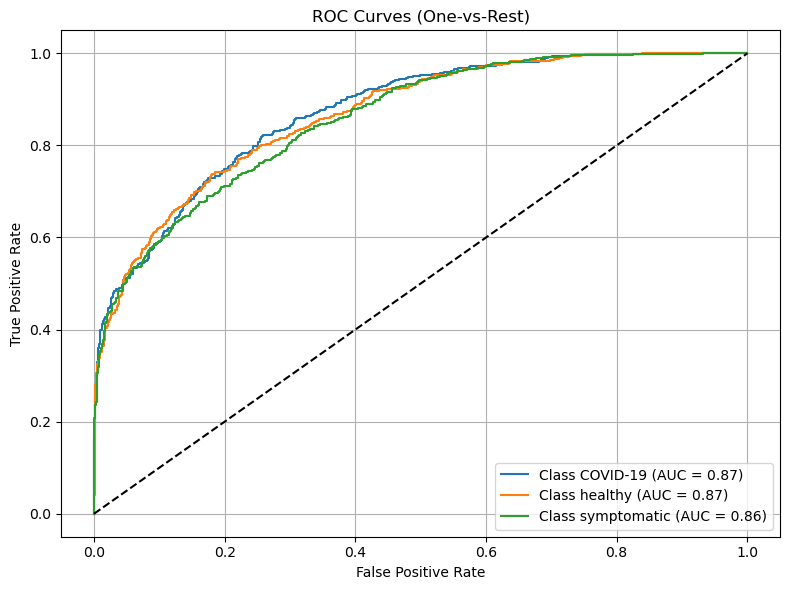


Classification Report (Test Data):
              precision    recall  f1-score   support

    COVID-19       0.65      0.64      0.64       450
     healthy       0.66      0.70      0.68       514
 symptomatic       0.72      0.71      0.72       714

    accuracy                           0.69      1678
   macro avg       0.68      0.68      0.68      1678
weighted avg       0.69      0.69      0.69      1678

Test Accuracy: 68.59%


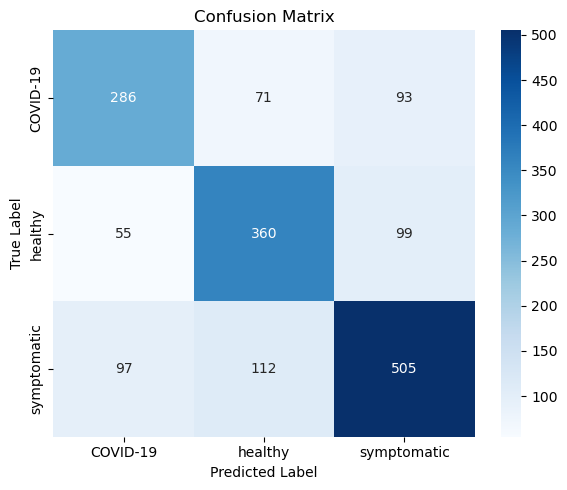

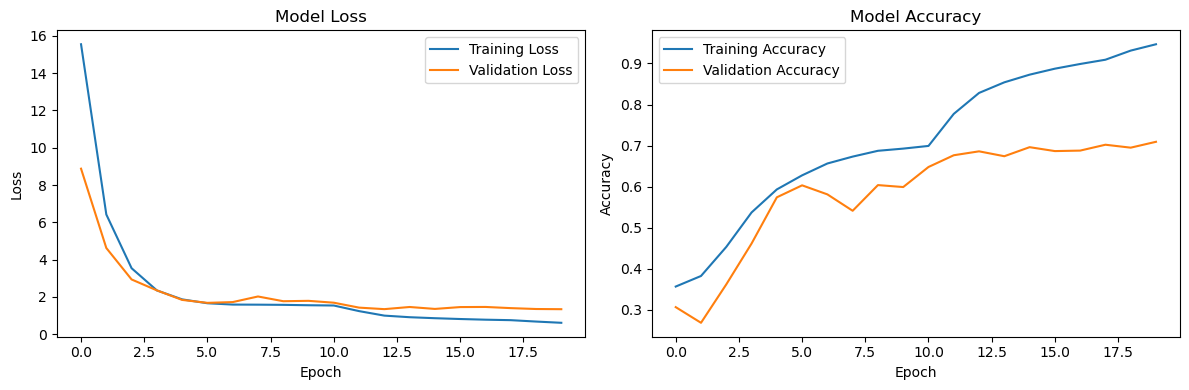

In [81]:
trainer = EnhancedCovidModelTrainerCNNLSTM(save_dir='model_artifacts') 
history = trainer.train(dataset_status, epochs=20, batch_size=128) 

In [107]:
import os
import numpy as np
import joblib
import pandas as pd
import tensorflow as tf
from colorama import Fore, Style
from tabulate import tabulate
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score
import matplotlib.pyplot as plt

class CovidPredictorCNNLSTM:
    def __init__(self, model_dir='model_artifacts'):
        self.model_dir = model_dir
        self.load_artifacts()

    def load_artifacts(self):
        """Load trained model and preprocessing artifacts."""
        try:
            self.model = tf.keras.models.load_model(f'{self.model_dir}/covid_model_cnn_lstm.keras')
            self.scaler = joblib.load(f'{self.model_dir}/scaler.pkl')
            self.label_encoder = joblib.load(f'{self.model_dir}/label_encoder.pkl')
            model_params = joblib.load(f'{self.model_dir}/model_params.pkl')

            self.height = model_params['height']
            self.width = model_params['width']
            self.channels = model_params['channels']
            self.sequence_length = model_params['sequence_length']
            print("Model and artifacts loaded successfully.")
        except Exception as e:
            print(f"Error loading artifacts: {e}")
            raise

    def preprocess_input(self, data):
        """Preprocess input data to match training format."""
        features = data.drop(columns=['uuid', 'status'], errors='ignore')

        # Check for missing columns
        expected_cols = self.scaler.feature_names_in_
        missing_cols = set(expected_cols) - set(features.columns)
        if missing_cols:
            raise ValueError(f"Missing columns in input data: {missing_cols}")

        features_normalized = self.scaler.transform(features)

        # Reshape to (batch_size, sequence_length, height, width, channels)
        features_reshaped = features_normalized.reshape(-1, self.sequence_length, self.height, self.width, self.channels)
        return features_reshaped

    def predict(self, dataset, n_samples=5, random_state=42):
        """Make predictions on a random subset of the dataset."""
        try:
            random_rows = dataset.sample(n=n_samples, random_state=random_state).reset_index(drop=True)
            uuids = random_rows['uuid'].astype(str)  # Ensure UUIDs are strings
            original_status = random_rows['status'].astype(str)  # Ensure original status is a string

            X_input = self.preprocess_input(random_rows)

            print("Input shape (before prediction):", X_input.shape)  # Debugging

            predictions = self.model.predict(X_input)
            predicted_classes = np.argmax(predictions, axis=1)
            predicted_labels = self.label_encoder.inverse_transform(predicted_classes)

            # Create DataFrame for Results
            predictions_df = pd.DataFrame({
                'UUID': uuids,
                'Original Status': original_status,
                'Predicted Status': predicted_labels
            })

            # Ensure all columns are strings for proper formatting
            predictions_df = predictions_df.astype(str)


            # Tabulate Output in Proper Format
            print("\nPrediction Results:")
            print(tabulate(predictions_df, headers='keys', tablefmt='grid'))

            # Compute Accuracy
            accuracy = np.mean(original_status == predicted_labels) * 100
            print(f"\nNumber of samples: {n_samples}")
            print(f"\nBatch Accuracy: {accuracy:.2f}%")

            # Calculate Confusion Matrix
            cm = confusion_matrix(original_status, predicted_labels, labels=self.label_encoder.classes_)

            # Display Confusion Matrix
            disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=self.label_encoder.classes_)
            disp.plot()
            plt.title('Confusion Matrix')
            plt.show()

            # --- ROC Curve Calculation and Plotting ---
            original_status_encoded = self.label_encoder.transform(original_status) # Encode original status to numerical
            plt.figure(figsize=(8, 6)) # Create a new figure for ROC curve
            n_classes = len(self.label_encoder.classes_)

            for i in range(n_classes):
                # Compute ROC curve for each class
                fpr, tpr, thresholds = roc_curve(original_status_encoded == i, predictions[:, i])
                roc_auc = roc_auc_score(original_status_encoded == i, predictions[:, i])
                plt.plot(fpr, tpr, lw=2, label=f'ROC curve for class {self.label_encoder.classes_[i]} (AUC = {roc_auc:.2f})')

            plt.plot([0, 1], [0, 1], color='gray', linestyle='--', lw=2, label='Baseline') # Diagonal line for random classifier
            plt.xlim([0.0, 1.0])
            plt.ylim([0.0, 1.05])
            plt.xlabel('False Positive Rate')
            plt.ylabel('True Positive Rate')
            plt.title('Receiver Operating Characteristic (ROC) Curve for each class')
            plt.legend(loc="lower right")
            plt.show()
            # --- End ROC Curve Calculation and Plotting ---


            return predictions_df
        except Exception as e:
            print(f"Error during prediction: {e}")
            return None  # Or handle as needed

Model and artifacts loaded successfully.
Input shape (before prediction): (8000, 1, 1, 199, 1)
250/250 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

Prediction Results:
+------+--------------------------------------+-------------------+--------------------+
|      | UUID                                 | Original Status   | Predicted Status   |
+======+======================================+===================+====================+
|    0 | 12519d8d-43bb-4ed7-9c76-03d3fb486c4a | symptomatic       | symptomatic        |
+------+--------------------------------------+-------------------+--------------------+
|    1 | d07e4f28-d901-4c74-a849-ccaa432173f8 | healthy           | healthy            |
+------+--------------------------------------+-------------------+--------------------+
|    2 | 0d930dca-d29e-4b69-a211-79ce69081c97 | healthy           | healthy            |
+------+--------------------------------------+-------------------+--------------------+
|    3 | 6c9a5f33-9e90-4c08-8782-20b0d86ab

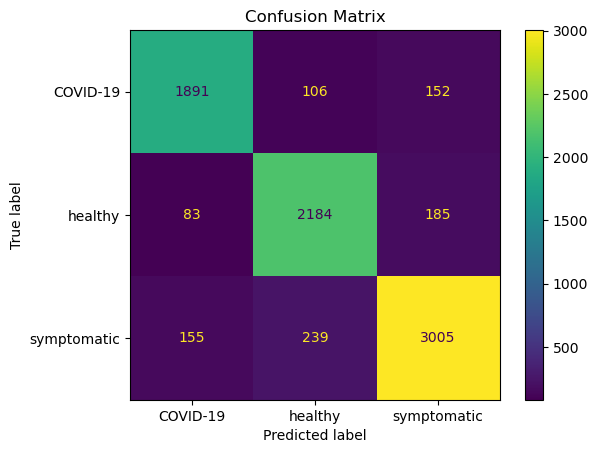

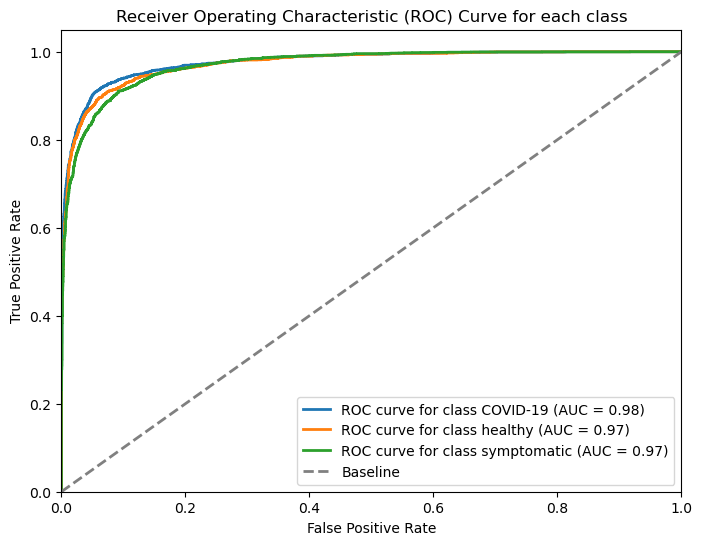

In [108]:
try:
    predictor = CovidPredictorCNNLSTM()
    results = predictor.predict(dataset_status, n_samples=8000)
except Exception as e:
    print(f"Error during prediction: {e}")